In [1]:
import sys
sys.path.append('../')

from low_rank_rnns.modules_connectivity_fullRank import *
from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering

from matplotlib import pyplot as plt
# %matplotlib notebook
import random
import numpy as np

import torch


size = 300
noise_std = 1e-2
alpha = .1
lr = 1e-3

input_size = 3
output_size = 1

# load a full-rank RNN
net1 = FullRankRNN(3, size, 1, noise_std, alpha)
net1.load_state_dict(torch.load(f'../models/3areas{size}.pt', map_location='cpu'))


# with torch.no_grad():
#     net1.wi.copy_(net.w_in_eff)
#     net1.wo.copy_(net.w_out_eff)
#     net1.wrec.copy_(net.w_rec_eff)


x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)

loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net1, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

loss=0.213, acc=1.000


In [2]:
attributes = net1.__dict__
attributes.keys()

dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', 'input_size', 'hidden_size', 'output_size', 'noise_std', 'alpha', 'rho', 'train_wi', 'train_wo', 'train_wrec', 'train_h0', 'train_si', 'train_so', 'non_linearity', 'output_non_linearity', 'wi_full', 'wo_full', 'w_rec_eff', 'w_in_eff', 'w_out_eff'])

In [3]:
# from sklearn.decomposition import PCA
# wrec_mask = net1.wrec_mask.cpu()

# X = wrec_mask.numpy()
# pca = PCA(n_components=10)
# X_proj = pca.fit_transform(X)
# X_recon = pca.inverse_transform(X_proj)
# plt.imshow(X_recon)

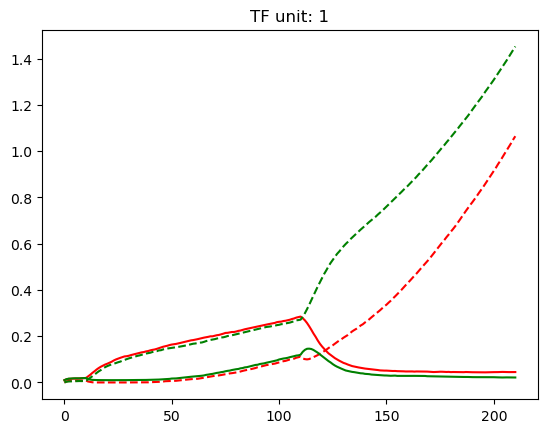

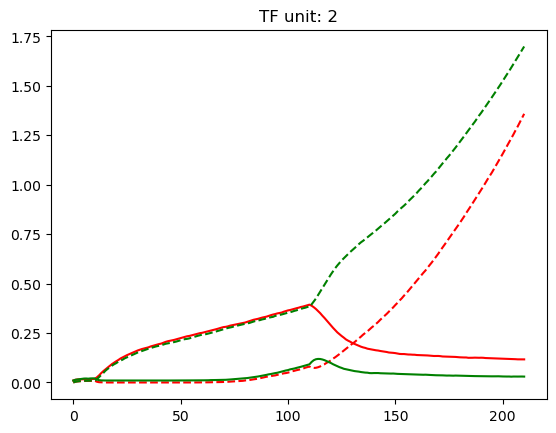

In [4]:
traj1 = traj.detach().numpy()

traj1 = np.maximum(traj1, 0)

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

for n in range(1,3):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n]+0.01, 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n]+0.01, 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))

In [5]:

# rank = 10



# # reduce the rank of connectivity matrix 
# wi_init = net1.wi.detach()
# wo_init = net1.wo.detach() * size
# print(wo_init.std())
# wrec = net1.wrec.detach().cpu().numpy()
# u, s, v = np.linalg.svd(wrec)
# m_init = torch.from_numpy(s[:rank] * u[:, :rank]).to(device=net1.wrec.device) * sqrt(size)
# n_init = torch.from_numpy(v[:rank, :].transpose()).to(device=net1.wrec.device) * sqrt(size)
# print(m_init.std())
# print(n_init.std())

# print(m_init.shape)
# print(n_init.shape)

In [6]:

rank = 10

# reduce the rank of connectivity matrix 
wi_init = net1.w_in_eff.detach()
wo_init = net1.w_out_eff.detach() * size
print(wo_init.std())
wrec = net1.w_rec_eff.detach().cpu().numpy()
u, s, v = np.linalg.svd(wrec)
n_init = torch.from_numpy(s[:rank] * u[:, :rank]).to(device=net1.w_rec_eff.device) * sqrt(size)
m_init = torch.from_numpy(v[:rank, :].transpose()).to(device=net1.w_rec_eff.device) * sqrt(size)
print(m_init.std())
print(n_init.std())

print(m_init.shape)
print(n_init.shape)

tensor(27.9594)
tensor(0.9976)
tensor(2.6714)
torch.Size([300, 10])
torch.Size([300, 10])


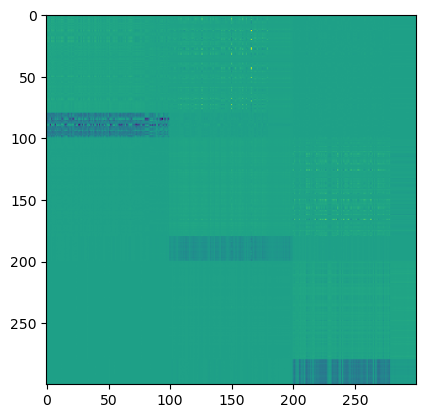

In [7]:
plt.imshow(n_init.matmul(m_init.t()))

In [8]:
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(10000)

# We see that the rank-1 network 
net_lo = LowRankRNN(3, size, 1, noise_std, alpha, rank=rank, wi_init=wi_init, wo_init=wo_init, m_init=m_init, n_init=n_init,
                    wrec_mask = net1.wrec_mask, wi_mask = net1.wi_mask, wo_mask = net1.wo_mask)

net_lo.non_linearity = torch.relu
net_lo.out_non_linearity = torch.eye


train(net_lo, x_train, y_train, mask_train, n_epochs=20, lr=lr, batch_size=100, keep_best=True, cuda=True, clip_gradient=1, early_stop=0.3)

x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net_lo)

loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')


Training...
initial loss: 0.613
epoch 0:  loss=0.402  (took 17.41 s) *
epoch 1:  loss=0.222  (took 17.14 s) *
loss=0.187, acc=1.000


In [10]:
att = net_lo.__dict__
att.keys()


dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', 'input_size', 'hidden_size', 'output_size', 'noise_std', 'alpha', 'rank', 'train_m', 'train_wi', 'train_wo', 'train_wrec', 'train_h0', 'train_si', 'train_so', 'non_linearity', 'output_non_linearity', 'wrec', 'wi_full', 'wo_full', 'out_non_linearity', 'w_rec_eff', 'w_in_eff', 'w_out_eff'])

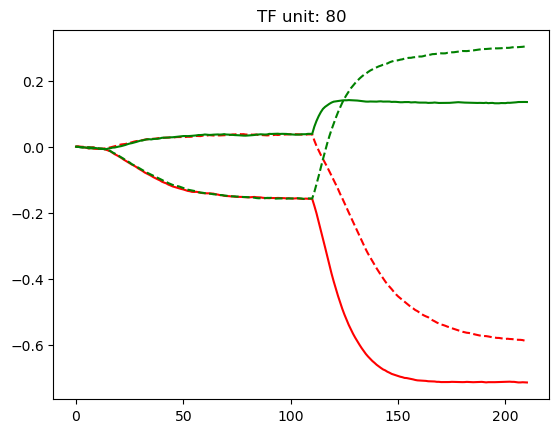

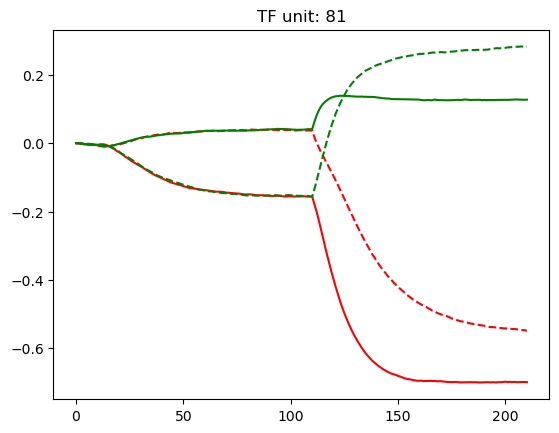

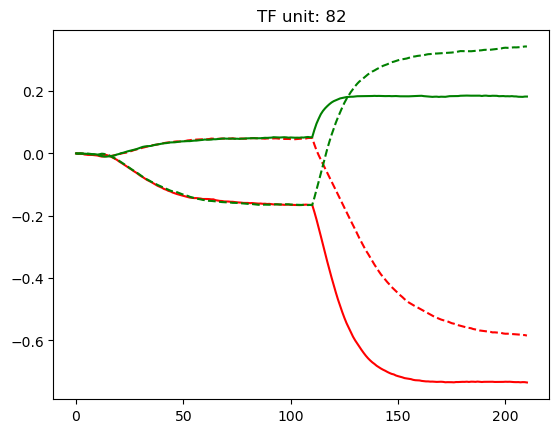

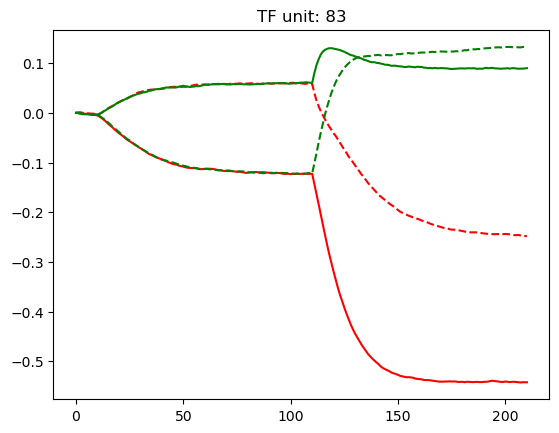

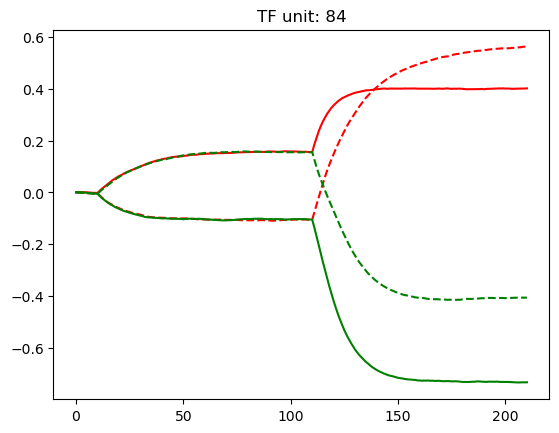

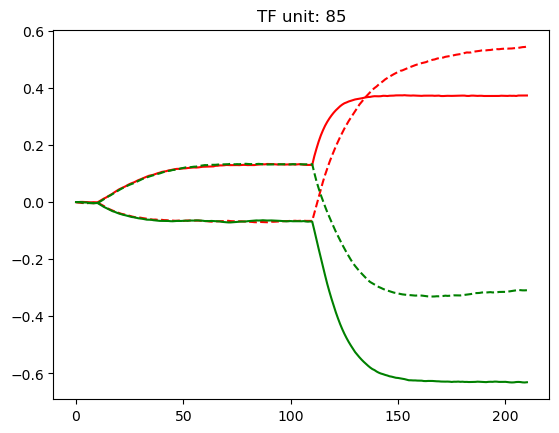

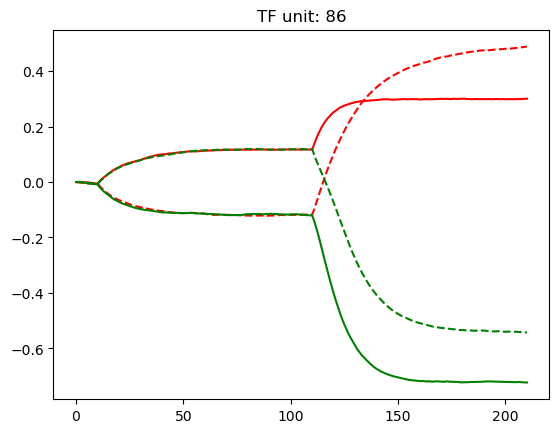

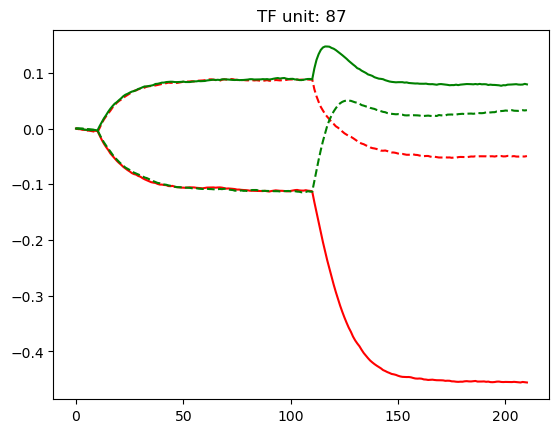

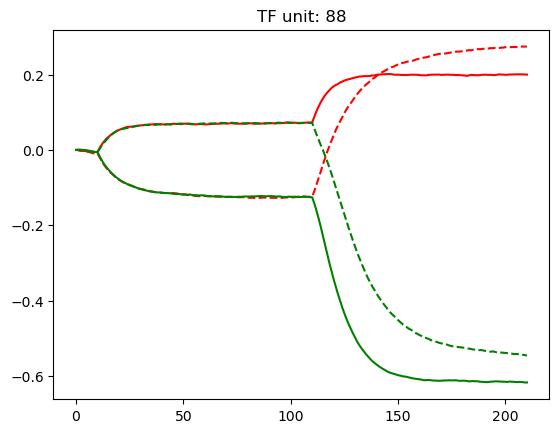

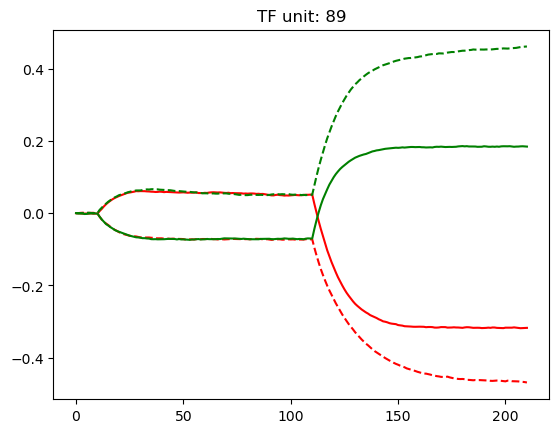

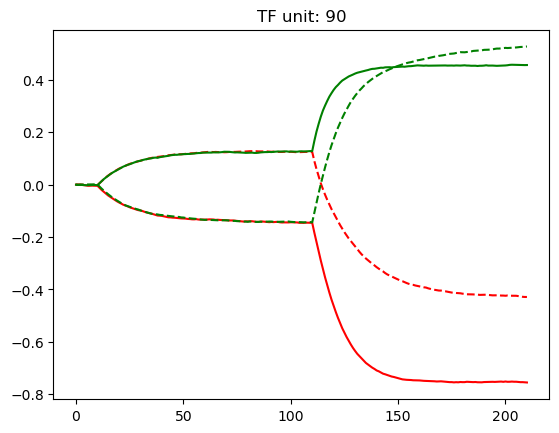

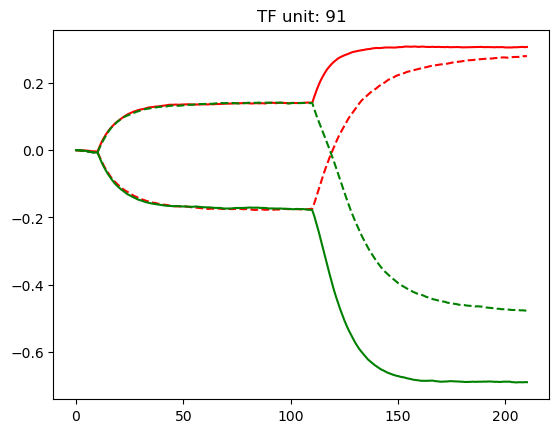

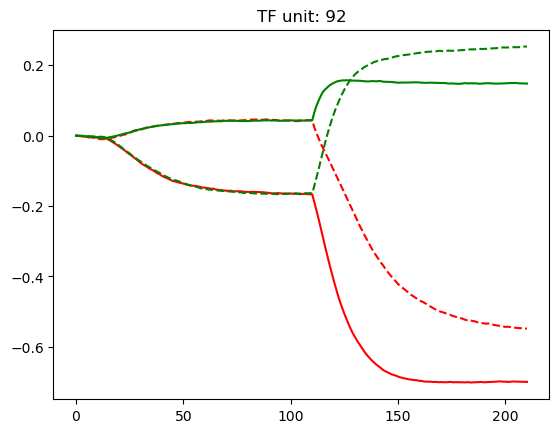

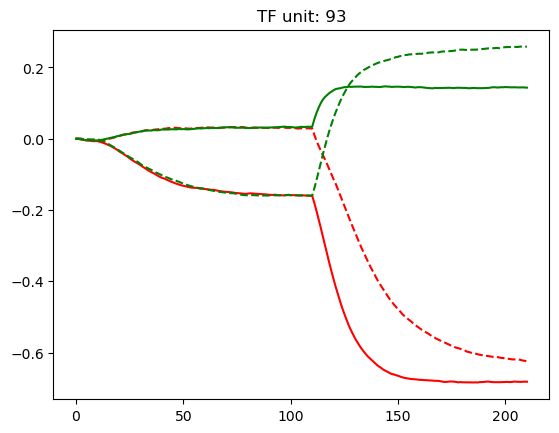

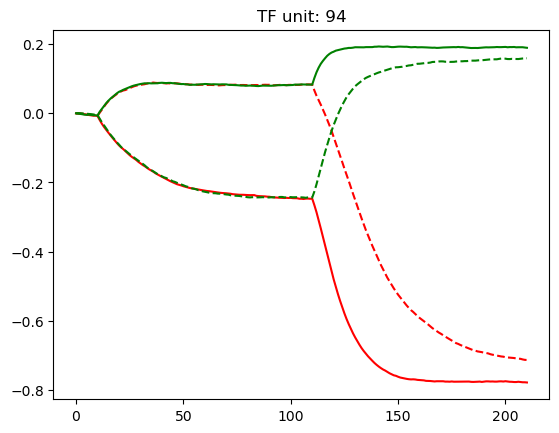

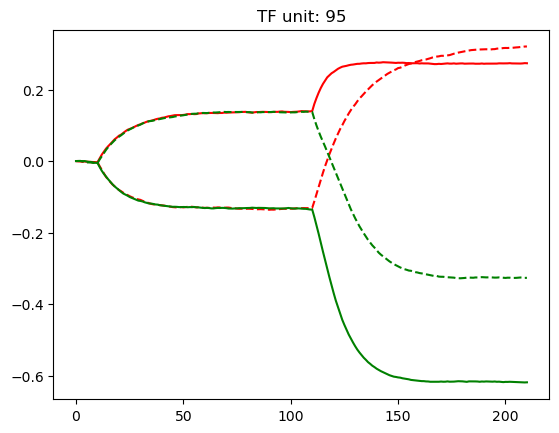

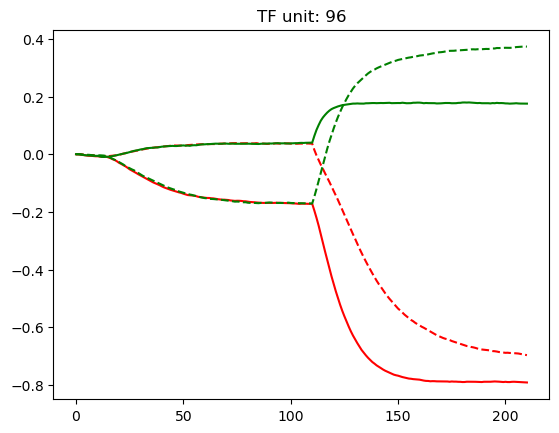

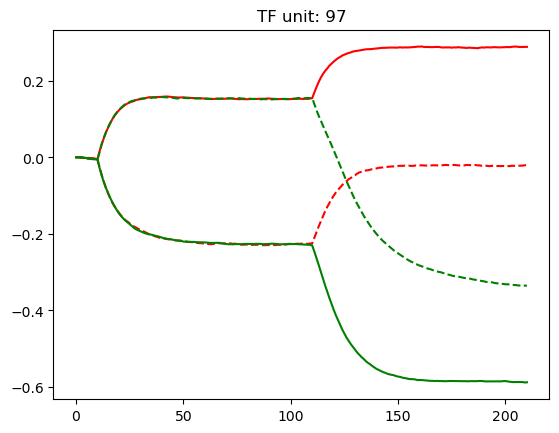

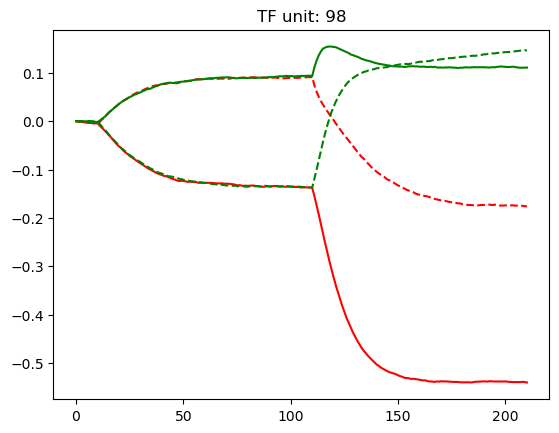

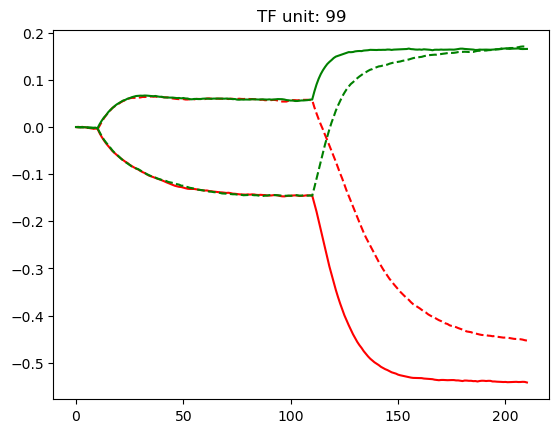

In [14]:
traj = traj.cpu()
decisions = decisions.cpu()
traj1 = traj.detach().numpy()

# traj1 = np.tanh(traj1)
decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

for n in range(80,100):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n], 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))

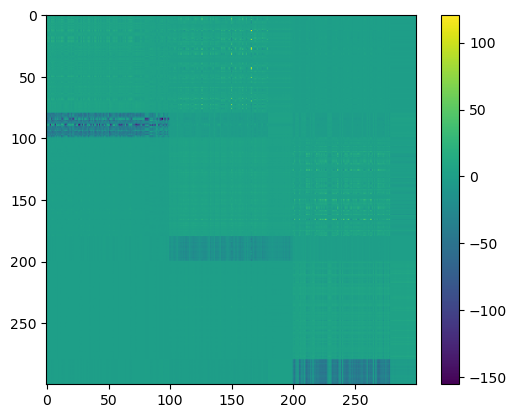

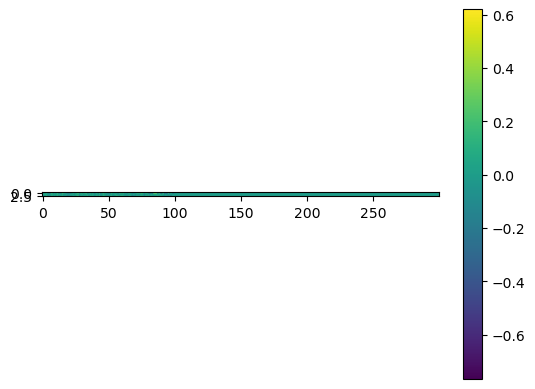

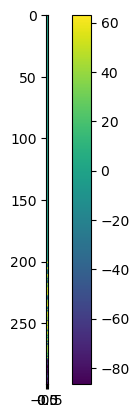

In [15]:
wrec = (net_lo.n.cpu()).matmul(net_lo.m.t().cpu())
wi = net_lo.wi.cpu()
wo = net_lo.wo.cpu()

a = wrec.detach().numpy()
plt.imshow(a)
plt.colorbar()
plt.set_cmap('viridis')
plt.show()

b = wi.detach().numpy()
plt.imshow(b)
plt.colorbar()
plt.set_cmap('viridis')
plt.show()

c = wo.detach().numpy()
plt.imshow(c)
plt.colorbar()
plt.set_cmap('viridis')
plt.show()
